<a href="https://colab.research.google.com/github/Patrick5455/Pharma-ML/blob/wip/non_web/analysis/interactive/Machine_learning_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
pip install hypopt

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import mean_squared_error
from hypopt import GridSearch
import xgboost as xgb
import pickle
from sklearn.externals import joblib 
from sklearn.base import BaseEstimator, TransformerMixin,RegressorMixin
from sklearn.model_selection import cross_val_score,cross_val_predict, KFold,train_test_split,GridSearchCV,RandomizedSearchCV

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
# na_value=['',' ','nan','Nan','NaN','na']
# train=pd.read_csv('./train.csv',na_values=na_value)
# store=pd.read_csv('./store.csv',na_values=na_value)
# test=pd.read_csv('./test.csv',na_values=na_value)

In [89]:
na_value=['',' ','nan','Nan','NaN','na']
train=pd.read_csv('/rossman_datasets/train.csv', sep=",",na_values=na_value)
store=pd.read_csv('/rossman_datasets/store.csv',sep=",",na_values=na_value)
test=pd.read_csv('/rossman_datasets/test.csv',sep=",",na_values=na_value)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [90]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [91]:
# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)
test.fillna(value = 1, inplace = True)

In [92]:
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [93]:
# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
train = train.sort_values(['Date'],ascending = False)
train_total = train.copy()

split_index = 6*7*1115
valid = train[:split_index] 
train = train[split_index:]

# only use data of Sales>0 and Open is 1
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]
train_total = train_total[(train_total.Open != 0)&(train_total.Sales >0)]


In [94]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
284584,314,5,2015-06-19,5032,562,1,1,0,0,a,a,3560.0,10.0,2001.0,1,31.0,2013.0,"Feb,May,Aug,Nov"
417104,458,5,2015-06-19,7362,688,1,1,0,0,c,a,3390.0,0.0,0.0,0,0.0,0.0,0
875290,961,5,2015-06-19,7764,768,1,1,0,0,d,c,9430.0,0.0,0.0,0,0.0,0.0,0
119580,132,5,2015-06-19,7964,692,1,1,0,0,d,c,1040.0,0.0,0.0,1,27.0,2012.0,"Jan,Apr,Jul,Oct"
807974,887,5,2015-06-19,7776,632,1,1,0,0,d,a,19700.0,0.0,0.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864127,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,0.0,0.0,0,0.0,0.0,0
321485,353,2,2013-01-01,3139,820,1,0,a,1,b,b,900.0,0.0,0.0,1,14.0,2013.0,"Feb,May,Aug,Nov"
249459,274,2,2013-01-01,3102,729,1,0,a,1,b,b,3640.0,0.0,0.0,1,10.0,2013.0,"Jan,Apr,Jul,Oct"
235513,259,2,2013-01-01,6851,1444,1,0,a,1,b,b,210.0,0.0,0.0,0,0.0,0.0,0


In [95]:
train.StoreType.unique()

array(['a', 'c', 'd', 'b'], dtype=object)

In [96]:
def process(data, isTest = False):
    # label encode some features
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    # extract some features from date column  
    data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    # calculate competiter open time in months
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    # calculate promo2 open time in months
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
    # Indicate whether the month is in promo interval
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)    
    
    # select the features we need
    features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']  
    if not isTest:
        features.append('Sales')
        
    data = data[features]
    return data

train = process(train)
valid = process(valid)
train_total = process(train_total)
x_test = process(test,isTest = True)

In [97]:
# sort by index
valid.sort_index(inplace = True)
train.sort_index(inplace = True)
train_total.sort_index(inplace = True)

# split x and y
x_train, y_train = train.drop(columns = ['Sales']), np.log1p(train['Sales'])
x_valid, y_valid = valid.drop(columns = ['Sales']), np.log1p(valid['Sales'])
x_train_total, y_train_total = train_total.drop(columns = ['Sales']), np.log1p(train_total['Sales'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
# define eval metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [99]:
clf = RandomForestRegressor(n_estimators = 15)
clf.fit(x_train, y_train)
# validation
y_pred = clf.predict(x_valid)
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1656


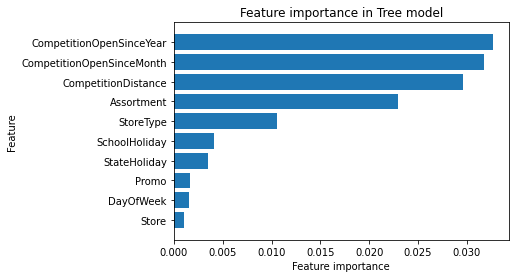

In [100]:
def plot_feature_importances(model,name):
    feature=pd.DataFrame({'imp':model.feature_importances_,'features':x_train.columns})
    feature=feature.sort_values(by='imp',ascending = True).head(10)
    n_features =feature.shape[0]
    plt.barh(range(n_features),feature.imp, align='center')
    plt.yticks(np.arange(n_features), x_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.title('Feature importance in Tree model')
    plt.savefig(name+'.jpg')
    return feature.features.values
features=plot_feature_importances(clf,'feature_importance')

In [101]:
params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_boost_round = 4000

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# train the xgboost model
model = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds= 100, feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.02074	eval-rmse:8.02783	train-rmspe:0.999809	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78063	eval-rmse:7.78784	train-rmspe:0.999711	eval-rmspe:0.999714
[2]	train-rmse:7.54784	eval-rmse:7.55441	train-rmspe:0.99959	eval-rmspe:0.999595
[3]	train-rmse:7.32187	eval-rmse:7.32809	train-rmspe:0.999443	eval-rmspe:0.999449
[4]	train-rmse:7.10286	eval-rmse:7.1073	train-rmspe:0.999266	eval-rmspe:0.999272
[5]	train-rmse:6.89032	eval-rmse:6.89425	train-rmspe:0.999052	eval-rmspe:0.99906
[6]	train-rmse:6.68423	eval-rmse:6.68674	train-rmspe:0.998797	eval-rmspe:0.998805
[7]	train-rmse:6.48425	eval-rmse:6.48719	train-rmspe:0.998494	eval-rmspe:0.998506
[8]	train-rmse:6.29026	eval-rmse:6.29359	train-rmspe:0.998138	eval-rmspe:0.998153
[9]	train-rmse:6.10209	eval-rmse:6.10611	train-rmspe:0.99772	eval-rmspe:0.99774
[10]	train-rmse:5.91965	eval-rmse:5.923

In [102]:
y_pred = model.predict(xgb.DMatrix(x_valid))
error = rmspe(np.expm1(y_valid), np.expm1(y_pred))
print('RMSPE: {:.4f}'.format(error))

RMSPE: 0.1312


Best weight is 0.995, RMSPE is 0.1228


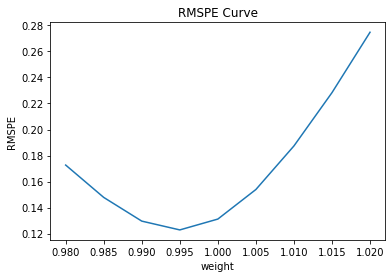

In [103]:
def correction():
    weights = np.arange(0.98, 1.02, 0.005)
    errors = []
    for w in weights:
        error = rmspe(np.expm1(y_valid), np.expm1(y_pred*w))
        errors.append(error)
        
    # make line plot
    plt.plot(weights, errors)
    plt.xlabel('weight')
    plt.ylabel('RMSPE')
    plt.title('RMSPE Curve')
    # print min error
    idx = errors.index(min(errors))
    print('Best weight is {}, RMSPE is {:.4f}'.format(weights[idx], min(errors)))
    
correction()

In [104]:
x_train_total.head().append(x_train_total.tail())

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
0,1,5,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,31,31,82.0,24187.75,0
1,1,4,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,30,31,82.0,24187.75,0
2,1,3,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,29,31,82.0,24187.75,0
3,1,2,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,28,31,82.0,24187.75,0
4,1,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,2015,7,27,31,82.0,24187.75,0
1017202,1115,1,1,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,7,2,24157.0,7.00,0
1017204,1115,6,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,5,1,24157.0,6.75,0
1017205,1115,5,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,4,1,24157.0,6.75,0
1017206,1115,4,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,3,1,24157.0,6.75,0
1017207,1115,3,0,0,1,4,3,5350.0,0.0,0.0,1,22.0,2012.0,2013,1,2,1,24157.0,6.75,0


In [105]:
dtrain = xgb.DMatrix(x_train_total, y_train_total)
dtest = xgb.DMatrix(x_test)
# specify parameters via map
params = {"objective": "reg:linear", # for linear regression
          "booster" : "gbtree",   # use tree based models 
          "eta": 0.03,   # learning rate
          "max_depth": 10,    # maximum depth of a tree
          "subsample": 0.9,    # Subsample ratio of the training instances
          "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
          "silent": 1,   # silent mode
          "seed": 10   # Random number seed
          }
num_round = 2000
model = xgb.train(params, dtrain, num_round)
# make prediction
preds = model.predict(dtest)

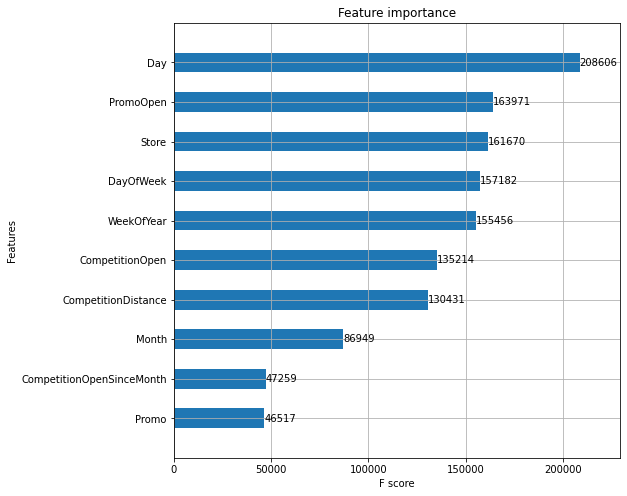

In [106]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, max_num_features= 10, height=0.5, ax=ax)
plt.show()

In [107]:
result = pd.DataFrame({"Id": test["Id"],'Sales': np.expm1(preds*0.995)})

Multiply the exponent of the predicted values with 0.995 

In [108]:
##One transformer for all
class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def check(self,row):
            if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
                return 1
            else:
                return 0

    def transform(self,data):
        self.cols=data.columns
        data = data.sort_values(['Date'],ascending = False)
        mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
        data.StoreType.replace(mappings, inplace=True)
        data.Assortment.replace(mappings, inplace=True)
        data.StateHoliday.replace(mappings, inplace=True)
    
        # extract some features from date column  
        data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)
        data['Month'] = data.Date.dt.month
        data['Year'] = data.Date.dt.year
        data['Day'] = data.Date.dt.day
        data['WeekOfYear'] = data.Date.dt.weekofyear
    
        # calculate competiter open time in months
        data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
            (data.Month - data.CompetitionOpenSinceMonth)
        data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
        # calculate promo2 open time in months
        data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
            (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
        data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
        # Indicate whether the month is in promo interval
        month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
        data['month_str'] = data.Month.map(month2str)
        if 'Sales' in self.cols:
            data = data[(data.Open != 0)&(data.Sales >0)]
        data['IsPromoMonth'] =  data.apply(lambda row: self.check(row),axis=1)    
    
        # select the features we need
        features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
           'StoreType', 'Assortment', 'CompetitionDistance',
           'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
           'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
           'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']  
        
        
        data = data[features]

        return data
        
        
        
        
       



In [109]:
class Regressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        x_train_total, y_train_total = X, np.log1p(y)
        dtrain = xgb.DMatrix(x_train_total, y_train_total)
        # specify parameters via map
        params = {"objective": "reg:linear", # for linear regression
                  "booster" : "gbtree",   # use tree based models 
                  "eta": 0.03,   # learning rate
                  "max_depth": 10,    # maximum depth of a tree
                    "subsample": 0.9,    # Subsample ratio of the training instances
                    "colsample_bytree": 0.7,   # Subsample ratio of columns when constructing each tree
                  "silent": 1,   # silent mode
                  "seed": 10   # Random number seed
          }
        num_round = 2000
        self.model = xgb.train(params, dtrain, num_round)
        return self
    
    def predict(self, X):
        dtest = xgb.DMatrix(X)
        predict=np.expm1(0.995*(self.model.predict(dtest)))
        return predict

In [110]:
X,y=train.drop(['Sales'],axis=1),train['Sales']
pipe = Pipeline(steps=[('preprocesssing',Preprocessing()),('Reg',Regressor())])
pipe.fit(X,y)

KeyError: ignored

In [ ]:
def save_as_date():
  dt=datetime.now()
  dt = datetime.strftime(x, "%m/%d/%Y-%H:%M:%S")
  file_name = dt+".pkl" 
  print(file_name)
  return file_name

In [ ]:
file_name = save_as_date()

In [ ]:
joblib.dump(pipe, open(file_name,compress=3 ))

In [ ]:
model = joblib.load(open('model.pkl'))

In [ ]:
pipe.predict(test)